# Assignment 2

In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns 
import datetime as dt
from numpy import absolute, sqrt, log
from scipy import stats
from textwrap import wrap
from IPython.display import Math, display

plt.rcParams['figure.dpi'] = 300

### Import data

In [2]:
DW = pd.read_csv('/Users/Kev/Documents/Uvic/Python/PHYS 411 - Time Series Analysis/Data Sets/WindWaveData.dat', 
                 sep='\s+')

In [3]:
# Import data
D1 = pd.read_csv('/Users/Kev/Documents/Uvic/Python/PHYS 411 - Time Series Analysis/Data Sets/UVicSci_temperature.dat', 
                 header=2)
D2 = pd.read_csv('/Users/Kev/Documents/Uvic/Python/PHYS 411 - Time Series Analysis/Data Sets/AllStations_temperature_h_2017.dat', 
                 sep='\s+', header=1, usecols=[0,35])

## My Functions:

### Correlation coeffcient:

$r_{xy} = \frac{
\sum_{i=1}^N (x_i - \bar{x})(y_i - \bar{y})}
{\left[ \sum_{i=1}^N(x_i - \bar{x})^2 \sum_{i=1}^N(y_i - \bar{y})^2 \right]^{\frac{1}{2}}
}$

In [4]:
def r(d, f, g):
    s = 0
    x = 0
    y = 0
    fm = np.nanmean(f)
    gm = np.nanmean(g)
    for i in range(len(d)):
        s += (f[i] - fm) * (g[i] - gm) 
        x += (f[i] - fm)**2
        y += (g[i] - gm)**2
        i += 1
    R = s / sqrt(x*y)
    return(R)

## Correlation check:

$-Z_\frac{\alpha}{2} \leq \frac{1}{2} \sqrt{N-3} \ln{\left(\frac{1+r_{xy}}{1-r_{xy}}\right)} \leq Z_{1-\frac{\alpha}{2}}$

In [5]:
def checkcorr(d, f, g, z):
    N = len(d)
    ru = 1 + r(d, f, g)
    rd = 1 - r(d, f, g)
    CC = 0.5 * sqrt(N-3) * log(ru/rd)
    if -(z+1) < CC < z+1: 
        print('Linear correlation exists at', 
              z*100,'level!')
    else:
        print('Nope! CC =', CC, 
              '\n Linear correlation does not exist at the', 
              z*100, '% level!')

## Regression line:

In [6]:
# Functions to calculate A and B
# Three of them to triple check, because I'm paranoid
def coeff1(d, f, g): 
    s1 = 0
    s2 = 0
    for i in range(len(d)):
        s1 += f[i]*g[i] 
        s2 += f[i]**2
    T = s1 - len(d)*np.nanmean(f)*np.nanmean(g)
    D = s2 - len(d)*np.nanmean(f)**2
    B = T/D
    A = np.nanmean(g) - np.nanmean(f)*B
    return(A, B)

def coeff2(d, f, g):
    s1 = 0
    s2 = 0
    for i in range(len(d)):
        s1 += (g[i]-np.nanmean(g))*f[i]
        s2 += (f[i]-np.nanmean(f))*f[i]
    B = s1/s2
    A = np.nanmean(g) - np.nanmean(f)*B
    return(A, B)

def coeff3(d, f, g):
    s1 = 0
    s2 = 0
    for i in range(len(d)):
        s1 += (f[i]-np.nanmean(f))*(g[i]-np.nanmean(g))
        s2 += (f[i]-np.nanmean(f))**2
    B = s1/s2
    A = np.nanmean(g) - np.nanmean(f)*B 
    return(A, B)

# Function to find the intercept
def a(f, g, B):
    a = np.nanmean(g) - np.nanmean(f)*B
    return(a)

## Uncertainty for regression: 
$S_\epsilon = \left[ \frac{1}{N-2} \sum (y_i - \tilde{y})^2 \right]^\frac{1}{2}$

In [7]:
def s_eps(d, f, g):   
    N = len(d)
    s1 = 0
    c = coeff1(d, f, g)
    for i in range(N):
        d = g[i] - c[0] - c[1]*f[i]
        s1 += d**2
    S_Eps = sqrt(s1/(N-2))
    return(S_Eps)

$S_x^2 = \frac{1}{N-1} \sum(x_i - \bar{x})^2$

In [8]:
def s_x2(d, f, g):    
    N = len(d)
    s1 = 0
    for i in range(N):
        d = f[i] - np.nanmean(f)
        s1 += d**2
    S_x2 = s1/(N-1)
    return(S_x2)

$S_x = \left[ \frac{1}{N-1} \sum(x_i - \bar{x})^2 \right]^\frac{1}{2}$

In [9]:
def s_x(d, f, g):  
    S_x = sqrt(s_x2(d, f, g))
    return(S_x)

$\delta b = \frac{S_\epsilon}{\sqrt{N-1} S_x^2}$

In [10]:
def uncert(d, f, g, p):
    N = len(d)
    D = sqrt(N-1)*s_x2(d, f, g)
    T = stats.t.ppf(1-(1-p)/2, N-1)
    Delta = s_eps(d, f, g)*T/D
    return(Delta)

## Expected interval/Uncertainty for mean:

$<x> = \bar{x} \pm t_{\frac{\alpha}{2}, N-1} \frac{S_x}{\sqrt{N}}$

In [11]:
def ExpValRange(f, p):
    N = len(f)
    ave = np.nanmean(f)
    T = stats.t.ppf(1-(1-p)/2, N-1)
    d = f
    g = 0
    sx = s_x(d, f, g)
    r2 = ave + T*sx/sqrt(N)
    r1 = ave - T*sx/sqrt(N)
    return(r1, r2)

## Question 1

### Plot Scatter Plot: 

Text(0, 0.5, 'Wave Height (m)')

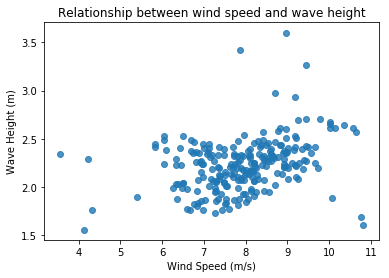

In [12]:
sns.regplot('WindSpeed', 'WaveHeight', data=DW, fit_reg = False)
plt.title('Relationship between %s and %s' %('wind speed', 'wave height'))
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Wave Height (m)')

Based on this plot, it is difficult to determine if wave height is dependent on wind speed. However, there is an increase in minimum wave height with respect to wind speed, which suggests that it may be affected by wind speed, and the data may be linearly dependent.   

### Find Correlation Coefficient: 

#### Finding the correlation coefficients using built in functions: 

In [13]:
DWC1 = np.corrcoef(DW['WaveHeight'], DW['WindSpeed'])
DWC2 = sci.stats.pearsonr(DW['WaveHeight'], DW['WindSpeed'])

print('Here are the expected values for the correlation coefficient:' 
      '\n Based on the "black box" \n')
print('Correlation coefficient matrix: \n', DWC1)
print('Correlation coefficient:', DWC1[1,0])
print('Pearson correlation coefficient:', DWC2[0])
# print('p-value:', DWC2[1])

Here are the expected values for the correlation coefficient:
 Based on the "black box" 

Correlation coefficient matrix: 
 [[1.         0.32062445]
 [0.32062445 1.        ]]
Correlation coefficient: 0.3206244479377165
Pearson correlation coefficient: 0.32062444793771644


#### Finding the correlation coefficient using my code:

In [14]:
WH = DW['WaveHeight']
WS = DW['WindSpeed']

# Get the correlation coeffcient
ruhs = r(DW, WS, WH)

# Check with "black box" values
if ruhs-DWC1[1,0] < 10**(-15):
    display(Math(r'r_{uH_s}=%.17f' % ruhs))
    print('Correlation coefficients match the'
          '"black box" correlation coefficients!')
else: 
    display(Math(r'r_{uH_s}=%.17f' % ruhs))
    print('IT IS WRONG YOU DONKEY!!!')
    

<IPython.core.display.Math object>

Correlation coefficients match the"black box" correlation coefficients!


#### Check for linear correlation at the 95% level using my code:

In [15]:
checkcorr(DW, WS, WH, 0.95)

Nope! CC = 5.08386956070061 
 Linear correlation does not exist at the 95.0 % level!


### Regression line: 

#### Find equation for regression line:

In [16]:
Coeff1 = coeff1(DW, WS, WH)
Coeff2 = coeff2(DW, WS, WH)
Coeff3 = coeff3(DW, WS, WH)

# coeff1, coeff2, coeff3, np.nanmean(WH), np.nanmean(WS)

#### Plot it out:

Slope =  0.0763178042687184
Intercept =  1.6253867451763844


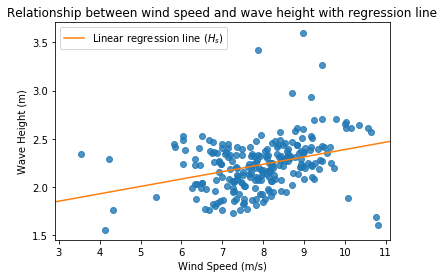

In [17]:
x = np.linspace(2.5, 12, 2)
y1 = Coeff1[0] + x*Coeff1[1]

sns.regplot('WindSpeed', 'WaveHeight', data=DW, fit_reg = False)
plt.title('Relationship between %s and %s with regression line'
          %('wind speed', 'wave height'))
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Wave Height (m)')
plt.plot(x, y1, label='Linear regression line ($H_s$)')
plt.xlim(2.9, 11.1)
plt.legend()

print('Slope = ', Coeff1[1])
print('Intercept = ', Coeff1[0])

## Regression lines with uncertainties 

### $H_s = a + (b \pm \delta b)u$

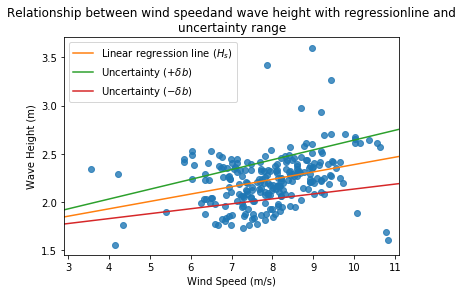

In [18]:
Delb = uncert(DW, WS, WH, 0.95)

x = np.linspace(2.5, 12, 2)
y1 = Coeff1[0] + x*Coeff1[1]
y2 = Coeff1[0] + x*(Coeff1[1]+Delb) 
y3 = Coeff1[0] + x*(Coeff1[1]-Delb) 

Title1 = wrap('Relationship between wind speed' 
              'and wave height with regression' 
              'line and uncertainty range')

sns.regplot('WindSpeed', 'WaveHeight', data=DW, fit_reg = False)
plt.title("\n".join(Title1))
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Wave Height (m)')
plt.plot(x, y1, label='Linear regression line ($H_s$)')
plt.plot(x, y2, label='Uncertainty ($+\delta b$)')
plt.plot(x, y3, label='Uncertainty ($-\delta b$)')
plt.xlim(2.9, 11.1)
plt.legend()

### $H_s = (a\pm \delta a) + (b \pm \delta b)u$

(+): Slope =  0.1016503591347917 Intercept =  1.4243862833662373
(-): Slope =  0.050985249402645094 Intercept =  1.8263872069865315


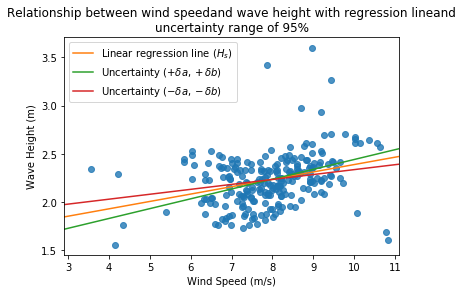

In [19]:
Delb = uncert(DW, WS, WH, 0.95)

x = np.linspace(2.5, 12, 2)
y1 = Coeff1[0] + x*Coeff1[1]
y2 = a(WS, WH, Coeff1[1]+Delb) + x*(Coeff1[1]+Delb) 
y3 = a(WS, WH, Coeff1[1]-Delb) + x*(Coeff1[1]-Delb) 

Title1 = wrap('Relationship between wind speed' 
              'and wave height with regression line'
              'and uncertainty range of 95%')

sns.regplot('WindSpeed', 'WaveHeight', data=DW, fit_reg = False)
plt.title("\n".join(Title1))
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Wave Height (m)')
plt.plot(x, y1, label='Linear regression line ($H_s$)')
plt.plot(x, y2, label='Uncertainty ($+\delta a, +\delta b$)')
plt.plot(x, y3, label='Uncertainty ($-\delta a, -\delta b$)')
plt.xlim(2.9, 11.1)
plt.legend()

print('(+): Slope = ', (Coeff1[1]+Delb), 
      'Intercept = ', a(WS, WH, Coeff1[1]+Delb))
print('(-): Slope = ', (Coeff1[1]-Delb), 
      'Intercept = ', a(WS, WH, Coeff1[1]-Delb))

### Scatter plot with regression line using built in functions:

/Users/Kev/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Wave height (m)')

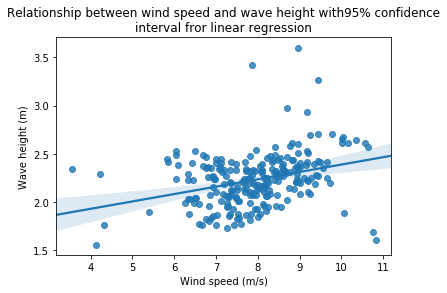

In [20]:
sns.regplot('WindSpeed', 'WaveHeight', data=DW, ci=95)
TitleReg = wrap('Relationship between %s and %s with' 
                '95%% confidence interval fror linear regression' 
              %('wind speed', 'wave height'))
plt.title("\n".join(TitleReg))
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Wave height (m)')

The regression lines for $H_s = (a\pm \delta a) + (b \pm \delta b)u$ looks like the graph generated using built-in functions in the Seaborn package. 

I can sleep peacefully now. 

### Expected range for wave heights 

In [21]:
WindSpeed = 10

def WHrange(ws):
    r1 = a(WS, WH, Coeff1[1]+Delb) + ws*(Coeff1[1]+Delb) 
    r2 = a(WS, WH, Coeff1[1]-Delb) + ws*(Coeff1[1]-Delb) 
    return(r1, r2)

print('Range for waveheights for windspeed of',
      WindSpeed, 'm/s is', WHrange(WindSpeed)[0], 
      'm to', WHrange(WindSpeed)[1], 'm')

Range for waveheights for windspeed of 10 m/s is 2.4408898747141543 m to 2.3362397010129823 m


## Question 2

### Clean up the minute resolution data

In [22]:
# Generate dates for D1 (minute resolution data)
date = pd.date_range(start='2011-12-31 17:00:00.000000', 
                     end='2017-08-30 16:59:00.000000', 
                     freq='min')
# date.size, D1.shape

In [23]:
# Insert dates into D1 dataframe
D1.insert(loc=0, column='Time', value=date)

# Rename the columns
D12 = D1.rename(index=str, columns={"2979360": "Temperature"})

# Set index
DM = D12.set_index('Time')

### Clean up the hourly resolution data

In [24]:
# Convert time in D2 from MatLab time to Python Time
D2['Time'] = D2['NaN'].apply(lambda matlab_datenum: 
                             dt.datetime.fromordinal(int(matlab_datenum)) 
                             + dt.timedelta(days=matlab_datenum%1)
                             - dt.timedelta(days = 366)) 

# Rename the columns
D22 = D2.rename(index=str, 
                columns={"NaN": "MatLab Time", "48.4623": "Temperature"})

In [25]:
# Reorder columns 
cols = D22.columns.tolist()
cols = cols[-1:] + cols[:-1]
D23 = D22[cols]

# Set time as index column
DH = D23.set_index('Time')

### Select the dates we want:

In [26]:
# Select the dates:
# Hour resolution data
DH15 = DH.loc['2015-08-07 00:00:00':'2015-08-07 23:59']
DH17 = DH.loc['2017-08-07 00:00:00':'2017-08-07 23:59']

# Minute resolution data
DM15 = DM.loc['2015-08-07 00:00:00':'2015-08-07 23:59']
DM17 = DM.loc['2017-08-07 00:00:00':'2017-08-07 23:59']

### Plot it out:

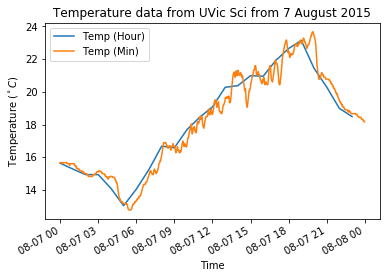

In [27]:
DH15['Temperature'].plot(label = 'Temp (Hour)')
DM15['Temperature'].plot(label = 'Temp (Min)')
plt.title('Temperature data from UVic Sci from 7 August 2015')
plt.ylabel('Temperature ($^\circ C$)')
plt.legend()

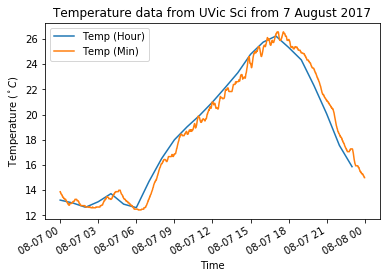

In [28]:
DH17['Temperature'].plot(label = 'Temp (Hour)')
DM17['Temperature'].plot(label = 'Temp (Min)')
plt.title('Temperature data from UVic Sci from 7 August 2017')
plt.ylabel('Temperature ($^\circ C$)')
plt.legend()

### Calculate the means 

In [29]:
# Means: 
DH17Mean = np.nanmean(DH17['Temperature'])
DH15Mean = np.nanmean(DH15['Temperature'])
DM17Mean = np.nanmean(DM17['Temperature'])
DM15Mean = np.nanmean(DM15['Temperature'])
 
display(Math(r'\mu_{H17}=%.10f' % DH17Mean)) 
display(Math(r'\mu_{M17}=%.10f' % DM17Mean))
display(Math(r'\mu_{H15}=%.10f' % DH15Mean)) 
display(Math(r'\mu_{M15}=%.10f' % DM15Mean))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean temperature for August 7, 2017: 18.6695833333 $^\circ C$ (Hour), 18.6695694444 $^\circ C$ (Min)

Mean temperature for August 7, 2015: 18.1379166667 $^\circ C$ (Hour), 18.1374513889 $^\circ C$ (Min)

### Determine with 95% confidence if 7 August 2017 is warmer than 7 August 2015

In [30]:
def isit(f, g):
    if f[0]<=g[1]<=f[1] or g[0]<=f[1]<=g[1]:
        print('Expected intervals overlap.'
              '\n7 August 2017 is not warmer ' 
              'than 7 August 2015 with 95% confidence.')
    else: 
        print('Expected intervals does not overlap.'
              '\n7 August 2017 is warmer ' 
              'than 7 August 2015 with 95% confidence.')
    return(' ')

print('Is Aug, 17 warmer in 2017 than in 15 based on the hour resolution data?')
RH17 = ExpValRange(DH17['Temperature'], 0.95)
RH15 = ExpValRange(DH15['Temperature'], 0.95)
print('2017 expected interval:', RH17, '\n2015 expected interval:', RH15)
print('2017 expected temperature:', DH17Mean, '+/-', DH17Mean-RH17[0], 
      '\n2015 expected temperature:', DH15Mean, '+/-', DH15Mean-RH15[0])
print(isit(RH17, RH15))

print('Is Aug, 17 warmer in 2017 than in 15 based on the minute resolution data?')
RM17 = ExpValRange(DM17['Temperature'], 0.95)
RM15 = ExpValRange(DM15['Temperature'], 0.95)
print('2017 expected interval:', RM17, '\n2015 expected interval:', RM15)
print('2017 expected temperature:', DM17Mean, '+/-', DM17Mean-RM17[0], 
      '\n2015 expected temperature:', DM15Mean, '+/-', DM15Mean-RM15[0])
print(isit(RM17, RM15))

Is Aug, 17 warmer in 2017 than in 15 based on the hour resolution data?
2017 expected interval: (16.64145069522452, 20.697715971442143) 
2015 expected interval: (16.862147660851505, 19.413685672481826)
2017 expected temperature: 18.669583333333332 +/- 2.0281326381088114 
2015 expected temperature: 18.137916666666666 +/- 1.2757690058151603
Expected intervals overlap.
7 August 2017 is not warmer than 7 August 2015 with 95% confidence.
 
Is Aug, 17 warmer in 2017 than in 15 based on the minute resolution data?
2017 expected interval: (18.42529046549471, 18.913848423394178) 
2015 expected interval: (17.982958041275783, 18.291944736501993)
2017 expected temperature: 18.669569444444445 +/- 0.24427897894973327 
2015 expected temperature: 18.137451388888888 +/- 0.15449334761310496
Expected intervals does not overlap.
7 August 2017 is warmer than 7 August 2015 with 95% confidence.
 
